In [1]:
%matplotlib inline
import matplotlib as mpl
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import math

In [2]:
top_n = 2
fn_exp = '../e1f6/test/pd_counts.csv'
fn_sim = '../e1f6/test/pd_counts_sim.csv'

def get_pd_counts(fn, pid=11, df_rat_e=None, df_rat_p=None):
    df = pd.read_csv(fn).dropna()
#     df = df[(df.Q2>2.25)&(df.W<2)]
    df_e = None if df_rat_e is None else df[(df.id==11)].merge(df_rat_e, on=['sect','pdl'], how='inner')[['evntid','eff','ko_eff']]
    df_p = None if df_rat_p is None else df[(df.id==2212)].merge(df_rat_p, on=['sect','pdl'], how='inner')[['evntid','eff','ko_eff']]
    df = df[(df.id==pid)&(df.sect>0)]
    if df_e is not None:
        df = df.merge(df_e, on='evntid', how='inner')
        df['w8'] = np.power(df.eff,-1)*df.ko_eff
        if df_p is not None:
            df = df.merge(df_p, on='evntid', how='inner', suffixes=['','_p'])
            df['w8'] = df.w8*np.power(df.eff_p,-1)*df.ko_eff_p*df.ko_eff
    else:
        df['w8'] = df.id/df.id # constant 1
    df_pdl_n = df.groupby(['sect','pdl']).w8.sum().reset_index()
    df_pdl_n['e'] = df_pdl_n.w8.apply(np.sqrt)
    df_pdl_n.columns = ['sect', 'pdl', 'n', 'e']
    df_pdl_n.set_index(['sect', 'pdl'], drop=False, inplace=True)
    return df_pdl_n

def get_eff(df_exp, df_sim):
    s_rat = df_exp.n/df_sim.n
    s_err = s_rat*np.sqrt(np.power(df_exp.e,2)/np.power(df_exp.e,4)+np.power(df_sim.e,2)/np.power(df_sim.e,4))
    df_rat = pd.concat([df_exp.sect, df_exp.pdl, s_rat, s_err], axis=1)
    df_rat.columns = ['sect', 'pdl', 'rat', 'err']
    df_pdl_norms = df_rat.reset_index(drop=True).groupby('pdl').rat.nlargest(top_n).reset_index().groupby('pdl').rat.mean().reset_index()
    df_pdl_norms.columns=['pdl', 'norm']
    df_rat = df_rat.merge(df_pdl_norms, on='pdl')
    df_rat['eff'] = df_rat.rat/df_rat.norm
    df_rat['eff_err'] = df_rat.err/df_rat.norm
    def knockout_bad(rec):
        bad_paddles = [
                        [1,5,7,24],
                        [2,5,11,16,28,38],
                        [3,2,11,24,25,27,28],
                        [4,5,7,19,24,30,34,42,45],
                        [5,2,15,18,20,21,28,34,36],
                        [6,1,6,18,40]
                      ]
        return 0 if int(rec.pdl) in bad_paddles[int(rec.sect)-1] else 1
    df_rat['ko_eff'] = df_rat.apply(knockout_bad, axis=1)
    return df_rat

def draw_pdl_eff(df_rat, ax=None):
    fig = None
    if ax is None:
        fig = plt.figure()
        ax = fig.axes[0]
    for k, g in df_rat.groupby('sect'):
        X, Y, Yerr = g.pdl.values, (g.eff*g.ko_eff).values, (g.eff_err*g.ko_eff).values
        fig = ax.errorbar(X, Y, yerr=Yerr, label=r'S%d'%k, fmt='.')
#     ax.legend(loc=(0.25,0.2), ncol=3, fontsize=10)
    ax.grid()
    ax.set_ylim(-0.05, 1.5)
    return fig

In [3]:
df_rat_e = get_eff(get_pd_counts(fn_exp, 11), get_pd_counts(fn_sim, 11))

In [4]:
df_rat_p = get_eff(get_pd_counts(fn_exp, 2212, df_rat_e), get_pd_counts(fn_sim, 2212))

In [5]:
df_rat_pip = get_eff(get_pd_counts(fn_exp, 211, df_rat_e, df_rat_p), get_pd_counts(fn_sim, 211))

In [6]:
df_rats = [get_eff(get_pd_counts(fn_exp, pid), get_pd_counts(fn_sim, pid))
           for pid in [11,2212,211]]

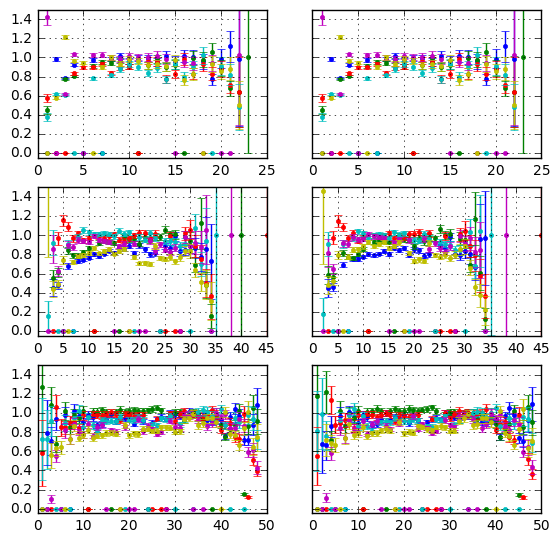

In [7]:
fig, axes = plt.subplots(3,2, figsize=(6.5, 6.5), sharey=True)
irow, icol = 0, 0
for (df_rat1, df_rat2) in zip(df_rats, [df_rat_e, df_rat_p, df_rat_pip]):
    draw_pdl_eff(df_rat1, axes[irow][0])
    draw_pdl_eff(df_rat2, axes[irow][1])
    irow += 1
plt.show()

In [9]:
w8_tot = None
for df_rat in [df_rat_e, df_rat_p, df_rat_pip]:
    mval = df_rat[['sect','pdl','eff','eff_err','ko_eff']][(df_rat.ko_eff>0)&(df_rat.eff>0)].eff.mean()
    print(mval)
    w8_tot = mval if w8_tot is None else w8_tot*mval
print(w8_tot)

0.894664364041
0.870813413335
0.894702911326
0.697050269586


In [10]:
w8_tot = None
for df_rat in df_rats:
    mval = df_rat[['sect','pdl','eff','eff_err','ko_eff']][(df_rat.ko_eff>0)&(df_rat.eff>0)].eff.mean()
    print(mval)
    w8_tot = mval if w8_tot is None else w8_tot*mval
print(w8_tot)

0.894664364041
0.8657632498
0.890166113445
0.689493765371


# Scratch

In [ ]:
fn_exp = '../e1f6/test/pd_counts.csv'
fn_sim = '../e1f6/test/pd_counts_sim.csv'
def get_pd_counts(fn, pid=11):
    df = pd.read_csv(fn)
    df_pdl_n = df[(df.id==pid)&(df.sect>0)].groupby(['sect','pdl']).id.count().reset_index()
    df_pdl_n['e'] = df_pdl_n.id.apply(np.sqrt)
    df_pdl_n.columns = ['sect', 'pdl', 'n', 'e']
    df_pdl_n.set_index(['sect', 'pdl'], drop=False, inplace=True)
    return df_pdl_n

def get_eff(df_exp, df_sim):
    s_rat = df_exp.n/df_sim.n
    s_err = s_rat*np.sqrt(np.power(df_exp.e,2)/np.power(df_exp.e,4)+np.power(df_sim.e,2)/np.power(df_sim.e,4))
    df_rat = pd.concat([df_exp.sect, df_exp.pdl, s_rat, s_err], axis=1)
    df_rat.columns = ['sect', 'pdl', 'rat', 'err']
    df_pdl_norms = df_rat.reset_index(drop=True).groupby('pdl').rat.nlargest(3).reset_index().groupby('pdl').rat.mean().reset_index()
    df_pdl_norms.columns=['pdl', 'norm']
    df_rat = df_rat.merge(df_pdl_norms, on='pdl')
    df_rat['eff'] = df_rat.rat/df_rat.norm
    df_rat['eff_err'] = df_rat.err/df_rat.norm
    def knockout_bad(rec):
        bad_paddles = [
                        [1,5,7,24],
                        [2,5,11,16,28,38],
                        [3,2,11,24,25,27,28],
                        [4,5,7,19,24,30,34,42,45],
                        [5,2,15,18,20,21,28,34,36],
                        [6,1,6,18,40]
                      ]
        return 0 if int(rec.pdl) in bad_paddles[int(rec.sect)-1] else 1
    df_rat['ko_eff'] = df_rat.apply(knockout_bad, axis=1)
    return df_rat

def draw_pdl_eff(df_rat):
    fig = plt.figure()
    for k, g in df_rat.groupby('sect'):
        X, Y, Yerr = g.pdl.values, (g.eff*g.ko_eff).values, (g.eff_err*g.ko_eff).values
        plt.errorbar(X, Y, yerr=Yerr, label=r'S%d'%k, fmt='.', figure=fig)
    plt.legend(loc=(0.25,0.2), ncol=3, fontsize=10)
    plt.grid()
    plt.ylim(-0.05, 1.5)
    return fig

In [28]:
df_exp = df_exp[df_exp.pdl<22]
df_sim = df_sim[df_sim.pdl<22]
s_rat = df_exp.n/df_sim.n
s_err = s_rat*np.sqrt(np.power(df_exp.e,2)/np.power(df_exp.e,4)+np.power(df_sim.e,2)/np.power(df_sim.e,4))
df_rat = pd.concat([df_exp.sect, df_exp.pdl, s_rat, s_err], axis=1)
df_rat.columns = ['sect', 'pdl', 'rat', 'err']

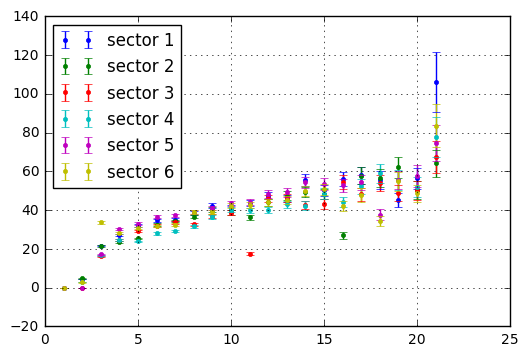

In [33]:
for k, g in df_rat[df_rat.pdl<25].groupby('sect'):
    X, Y, Yerr = g.pdl.values, g.rat.values, g.err.values
    plt.errorbar(X, Y, yerr=Yerr, label=r'sector %d'%k, fmt='.')
plt.legend(loc='best')
plt.grid()

In [60]:
df_pdl_norms = df_rat.reset_index(drop=True).groupby('pdl').rat.nlargest(2).reset_index().groupby('pdl').rat.mean().reset_index()
df_pdl_norms.columns=['pdl', 'norm']

In [62]:
df_rat = df_rat.merge(df_pdl_norms, on='pdl')
df_rat['eff'] = df_rat.rat/df_rat.norm

In [64]:
df_rat['eff_err'] = df_rat.err/df_rat.norm

In [73]:
def knockout_bad(rec):
    bad_paddles = [
                    [1,5,7,24],
                    [2,5,11,16,28,38],
                    [3,2,11,24,25,27,28],
                    [4,5,7,19,24,30,34,42,45],
                    [5,2,15,18,20,21,28,34,36],
                    [6,1,6,18,40]
                  ]
    return 0 if int(rec.pdl) in bad_paddles[int(rec.sect)-1] else 1

In [76]:
df_rat['ko_eff'] = df_rat.apply(knockout_bad, axis=1)

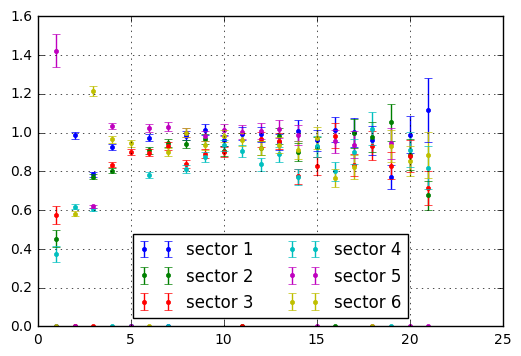

In [84]:
for k, g in df_rat.groupby('sect'):
    X, Y, Yerr = g.pdl.values, (g.eff*g.ko_eff).values, (g.eff_err*g.ko_eff).values
    plt.errorbar(X, Y, yerr=Yerr, label=r'sector %d'%k, fmt='.')
plt.legend(loc='lower center', ncol=2)
plt.grid()

In [85]:
df_rat[['sect','pdl','eff','eff_err','ko_eff']][(df_rat.ko_eff>0)].eff.mean()

0.90432721872471067